In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import StratifiedKFold

from helper_functions.classification import *
from helper_functions.botnet_profiling_task import *
from helper_functions.flow_data_discretization import *

The 10th scenario (https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-51/) will be used again, in order to compare with the performance metrics acquired from all the utilized methods.

First load the data of the 10th scenario and apply the same preprocessing.

In [2]:
data = pd.read_csv('./data/capture20110818.pcap.netflow.labeled.remastered')
data[['Src_IP_Addr', 'Src_Port']] = data['Src_IP_Addr:Port'].str.split(':', n=1, expand=True)
data[['Dst_IP_Addr', 'Dst_Port']] = data['Dst_IP_Addr:Port'].str.split(':', n=1, expand=True)

data['Datetime'] = data['#Date_flow'].str.cat(data['start'], sep=' ')
#data['Datetime'] = pd.to_datetime(data['Datetime'], infer_datetime_format=True)

data.drop(labels=['#Date_flow', 'start', 'Src_IP_Addr:Port', 'Dst_IP_Addr:Port'], axis=1, inplace=True)
data.head()

,Durat,Prot,Flags,Tos,Packets,Bytes,Flows,Label,Src_IP_Addr,Src_Port,Dst_IP_Addr,Dst_Port,Datetime
0,0.002,TCP,FRPA_,0,4,321,1,Background,147.32.86.166,33426,212.24.150.110,25443,2011-08-18 10:19:13.328
1,4.995,UDP,INT,0,617,40095,1,Background,82.39.2.249,41915,147.32.84.59,43087,2011-08-18 10:19:13.328
2,4.996,UDP,INT,0,1290,1909200,1,Background,147.32.84.59,43087,82.39.2.249,41915,2011-08-18 10:19:13.329
3,0.000,TCP,A_,0,1,66,1,Background,147.32.86.166,42020,147.32.192.34,993,2011-08-18 10:19:13.330
4,0.000,TCP,FPA_,0,2,169,1,Background,212.24.150.110,25443,147.32.86.166,33426,2011-08-18 10:19:13.330


NaNs do occur in features `Src_Port` and `Dst_Port` which will not be further utilized for this taks. Hence, no further action is taken.

In [3]:
nans = data.isna().values
np.sum(nans, axis=0)

array([     0,      0,      0,      0,      0,      0,      0,      0,
            0, 374017,      0, 375948,      0])

Drop all background flows and delete the original dataframe (save memory resources!)

In [4]:
data_nobground = data[ data['Label'] != 'Background']
data_nobground.shape
data_nobground.head()

del data

Hosts documented as infected and normal in the documentation of the scenario 51 (https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-51/) 

In [5]:
infected_hosts = ['147.32.84.165','147.32.84.191','147.32.84.192','147.32.84.193','147.32.84.204',
                  '147.32.84.205','147.32.84.206', '147.32.84.207','147.32.84.208','147.32.84.209']

normal_hosts = ['147.32.84.170', '147.32.84.134', '147.32.84.164', '147.32.87.36', '147.32.80.9', '147.32.87.11']

Initial conversion of features `Prot` and `Flags` to numeric. Additionally, `BOTNET` is mapped as the positive label.

In [6]:
# Storing the mapping used for the conversion, in case we want to revert back 
label_mapping = {}


label_mapping['Label'] = {'LEGITIMATE':0, 'Botnet':1}
data_nobground.replace({'Label' : label_mapping['Label']}, inplace=True)

# Convert all the rest columns which are of type 'object'
char_cols = ['Prot', 'Flags']

for c in char_cols:
    data_nobground[c], label_mapping[c] = pd.factorize(data_nobground[c])

# Uncomment this line, if you want to see the mapppings for the conversion
label_mapping

{'Label': {'LEGITIMATE': 0, 'Botnet': 1},
 'Prot': Index(['TCP', 'UDP', 'ICMP'], dtype='object'),
 'Flags': Index(['PA_', 'A_', 'FA_', 'SPA_', 'FPA_', 'INT', 'FSA_', '_FSA', 'FSPA_',
        '_FSPA', 'S_', 'RA_', 'FSRPA_', 'SA_', '_FSRPA', 'SRPA_', 'FRPA_',
        'ECO', 'URH', 'SR_', 'FRA_', 'RPA_', 'R_', 'FSPAEC_', 'SRA_', '_FSRA',
        'URP', 'PAC_', 'MAS', 'TST', 'IRR', 'ECR', 'RTS', 'RTA', 'IRQ', 'UNK',
        'MSR', 'TSR', 'SEC', 'ROB', 'MRQ', 'RED', 'IAH', 'TXD', 'DNQ', 'PTB',
        'PAR', 'NRA', 'WAY', 'PHO', '___', 'AHA', 'NRS', 'MHR', 'UR', 'NNA',
        'MRP', 'TRC', 'DCE', 'SKP', 'SRC', 'NNS', 'DNP', 'URN', 'URPRE', 'URS',
        'URNU', 'URCUT', 'URISO', 'URNPRO', 'URHPRO', 'URHTOS', 'URHU', 'SPAC_',
        'SEC_', 'FSRA_', 'URFIL', 'FSPAC_'],
       dtype='object')}

## Botnet profiling task
Here we will test the effect of introducing adversarial perturbations to the malicious host data. We are following the same approach (CNG method) as the corresponding task, thus first extracting two training profiles corresponding to *Infected* and *Normal* classes and then for each unseen-test host, extract its profile and classify based on 1-Nearest Neighbour (for further info please refer to https://web.cs.dal.ca/~vlado/papers/pst04.pdf)

Test-unseen hosts, excluding the first infected and normal hosts, which were used for the extraction of the corresponding training profiles.

In [7]:
test_hosts = np.append(infected_hosts[1:], normal_hosts[1:])
test_hosts

array(['147.32.84.191', '147.32.84.192', '147.32.84.193', '147.32.84.204',
       '147.32.84.205', '147.32.84.206', '147.32.84.207', '147.32.84.208',
       '147.32.84.209', '147.32.84.134', '147.32.84.164', '147.32.87.36',
       '147.32.80.9', '147.32.87.11'], dtype='<U13')

Discretize packets, smililar to the corresponding taks.

In [8]:
ranks = 2

packets = data_nobground['Packets'].values
data_nobground['Disc_Packets'] = discretize_ordinal(packets, ranks)

Extract infected and normal profiles

In [9]:
n = 2 
feat = ['Prot', 'Disc_Packets']
use_smoothing = False

# Extracting the infected training profile
infected_data = data_nobground[np.logical_or(data_nobground['Src_IP_Addr'] == infected_hosts[0], data_nobground['Dst_IP_Addr']==infected_hosts[0])]
infected_data = infected_data[feat].values

infected_code, _ = extract_code(infected_data)
infected_ngrams = extract_ngrams(infected_code, n)
unique_infected_ngrams, unique_infected_counts = np.unique(infected_ngrams, axis=0, return_counts=True)
if use_smoothing:
    max_unigram = np.max(unique_infected_ngrams)
    smoothed_infected_ngrams, smoothed_infected_counts = laplace_smoothing(unique_infected_ngrams, unique_infected_counts, max_unigram)
    _, infected_prof, infected_sorted_prof = extract_profile(smoothed_infected_ngrams, smoothed_infected_counts)
else:
    _, infected_prof, infected_sorted_prof = extract_profile(unique_infected_ngrams, unique_infected_counts)

# Extracting the normal profile
normal_data = data_nobground[np.logical_or(data_nobground['Src_IP_Addr'] == normal_hosts[0], data_nobground['Dst_IP_Addr']==normal_hosts[0])]
normal_data = normal_data[feat].values

normal_code, _ = extract_code(normal_data)
normal_ngrams = extract_ngrams(normal_code, n)
unique_normal_ngrams, unique_normal_counts = np.unique(normal_ngrams, axis=0, return_counts=True)
if use_smoothing:
    smoothed_normal_ngrams, smoothed_normal_counts = laplace_smoothing(unique_normal_ngrams, unique_normal_counts, max_unigram)
    _, normal_prof, normal_sorted_prof = extract_profile(smoothed_normal_ngrams, smoothed_normal_counts)
else:
    _, normal_prof, normal_sorted_prof = extract_profile(unique_normal_ngrams, unique_normal_counts)

For every test host, extract the instance profile and corresponding distances to the infected and normal profile. Classify the host to the nearest training profile. For the utilized distance metric please refer to the report or to https://web.cs.dal.ca/~vlado/papers/pst04.pdf.

Regarding the introduced perturbations, we only introduce them to malicious hosts (these are the hosts we want to camouflage as normal). For the perturbations we considered the max perturbations for the `Packet` feature. Since this method uses the discretized Packets (ordinally discretized), the effect of applying these perturbations is equivalent to map all `Disc_Packets` data of malicious hosts to 1. This is a quite significant aspect of the method, making it quite robust against introduced perturbations; no matter how big perturbations we introduce to `Packets`, the effect on `Disc_Packets` will be an increase of 1.

We also plot the distances to the two training profiles. The method is still able to classify all hosts correctly (robust against perturbations), but from the printed distances we can see that distances to the two profiles are almost equal now suggesting that our attack had impact.

In [10]:
pred = np.zeros(len(test_hosts), dtype=int)
i=0
for host in test_hosts:
    host_data = data_nobground[np.logical_or(data_nobground['Src_IP_Addr'] == host, data_nobground['Dst_IP_Addr']==host)]
    if len(host_data)<n:
#         print(host, len(host_data), '\n')
        i = i+1
        continue
    host_data = host_data[feat].values
    if host in infected_hosts:
        host_data[:,1] = 1
    
    host_code, _ = extract_code(host_data)
    host_ngrams = extract_ngrams(host_code, n)
    unique_host_ngrams, unique_host_counts = np.unique(host_ngrams, axis=0, return_counts=True)
    if use_smoothing:
        smoothed_host_ngrams, smoothed_host_counts = laplace_smoothing(unique_host_ngrams, unique_host_counts, max_unigram)
        _, host_prof, sorted_host_prof = extract_profile(smoothed_host_ngrams, smoothed_host_counts)
    else:
        _, host_prof, sorted_host_prof = extract_profile(unique_host_ngrams, unique_host_counts)
    
    normal_distance = distance(normal_prof, host_prof, normal_sorted_prof, sorted_host_prof, 2)
    infected_distance = distance(infected_prof, host_prof, infected_sorted_prof, sorted_host_prof, 2)
    
    print(host, normal_distance, infected_distance)
    if infected_distance < normal_distance:
        
        pred[i] = 1

    i = i+1

147.32.84.191 14.807843124877216 12.27442275322146
147.32.84.192 14.84089131993831 12.036581276623828
147.32.84.193 14.46490030637481 12.562196359461414
147.32.84.204 14.750423656852744 12.884101213479537
147.32.84.205 14.917606332503993 11.384842746175078
147.32.84.206 14.51456219080532 13.09418679004854
147.32.84.207 14.50434566494421 12.94648842590981
147.32.84.208 14.859585504332706 12.372431744225006
147.32.84.209 14.39336976834814 13.137175471469149
147.32.84.134 1.088094695258738 6.723669716018827
147.32.84.164 0.7706928831529345 6.445780858926657
147.32.87.36 1.4993154575822765 3.8579689061516693
147.32.80.9 12.937225458750717 14.516932912523624


Performance metrics

In [11]:
TP = np.sum(np.isin(test_hosts[pred==1], infected_hosts))
FP = np.sum(pred==1) - TP
TN = np.sum(np.isin(test_hosts[pred==0], infected_hosts, invert=True))
FN = np.sum(pred==0) - TN
print("TP: ", TP)
print("FP: ", FP)
print("FN: ", FN)
print("TN:", TN)
print(TP+FP+TN+FN)

TP:  9
FP:  0
FN:  0
TN: 5
14


Demonstration of the effect of introduced perturbations. In the follwing plot the infected and normal training profiles are plotted, along with an "adversarially perturbed" malicious host. We see that the ecxtracted host profile does now resemble more a normal profile, comparing to the case without the perturbations. However, the method is quite robust to these perturbations, as explained above, hence everything is classified correctly. 

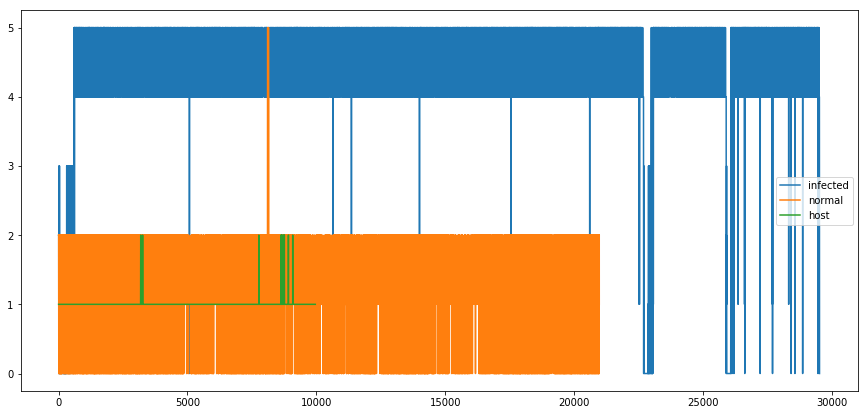

In [12]:
plt.figure(figsize=(15,7))
plt.plot(infected_code, label='infected')
plt.plot(normal_code, label='normal')
plt.plot(host_code, label='host')

plt.legend()

## Flow Classification
We will introduce perturbations as in https://ieeexplore.ieee.org/abstract/document/8548327. Features `Durat`, `Packets`, `Bytes` of test malicious hosts will be perturbed, increased by a set offset. 

For our attack we just perturb malicious test data; we do not interfere with the training of the model (to resemble a realistic scenario, where the attack occurs on a trained model). That is, in each cross-validation run, the model is trained on original data and then we "adversarially" perturb the aforementioned features of malicious hosts.  

### Host Level

In [13]:
data_nobground.head()

,Durat,Prot,Flags,Tos,Packets,Bytes,Flows,Label,Src_IP_Addr,Src_Port,Dst_IP_Addr,Dst_Port,Datetime,Disc_Packets
20,4.985,0,0,0,91,86277,1,0,147.32.80.13,80,147.32.85.88,56949,2011-08-18 10:19:13.347,1
51,0.000,0,1,0,1,66,1,0,147.32.86.110,48102,74.125.232.214,443,2011-08-18 10:19:13.392,0
57,4.921,0,1,0,49,3234,1,0,147.32.85.88,56949,147.32.80.13,80,2011-08-18 10:19:13.411,1
73,4.742,0,1,0,118,7080,1,0,147.32.84.59,2768,74.125.108.208,80,2011-08-18 10:19:13.460,1
75,0.000,0,1,0,1,60,1,0,147.32.84.59,56058,74.125.232.215,443,2011-08-18 10:19:13.486,0


Extract data per host. We also extract some extra features per-host, that is the amount of unique `Dst_IP_Addr` this hosts connects to, as well as the unique number of `Src_Port` and `Dst_Port` utilized.

For the labels, we do consider as infected a host which has took part in a malicious flow as source.

In [14]:
data_perhost = data_nobground.groupby(by='Src_IP_Addr').agg({'Durat':'sum', 'Prot':'sum', 'Flags':'sum', 'Tos':'sum', 'Packets':'sum', 'Bytes':'sum', 'Flows':'sum', 'Label':'max'})
data_perhost['Dst_IPs'] = data_nobground.groupby('Src_IP_Addr')['Dst_IP_Addr'].nunique()
data_perhost['Src_Ports'] = data_nobground.groupby('Src_IP_Addr')['Src_Port'].nunique()
data_perhost['Dst_Ports'] = data_nobground.groupby('Src_IP_Addr')['Dst_Port'].nunique()

hosts = data_perhost.index

labels = data_perhost['Label'].values
data_perhost.drop(labels='Label', axis=1, inplace=True)
X = data_perhost.values

print(X.shape)
print("Imbalance ratio: ", np.sum(labels)/np.sum(labels==0))

(522, 10)
Imbalance ratio:  0.14725274725274726


In [15]:
data_perhost.head()

,Durat,Prot,Flags,Tos,Packets,Bytes,Flows,Dst_IPs,Src_Ports,Dst_Ports
Src_IP_Addr,,,,,,,,,,
10.10.20.233,50.096,0,249,0,132,8712,75,1,23,1
10.168.115.232,3.624,0,20,0,9,778,5,1,1,1
10.168.48.160,4.897,0,16,0,6,534,4,1,1,1
10.23.106.55,3.565,0,8,0,6,511,2,1,1,1
10.23.12.43,4.556,0,16,0,6,1583,4,2,2,2


Demonstration of the class distribution. Clearly, normal hosts are the majority but there is no significant imbalance.

Infected hosts:  67
Normal hosts:  455
Imbalance ratio:  0.12835249042145594


Text(0, 0.5, 'Counts')

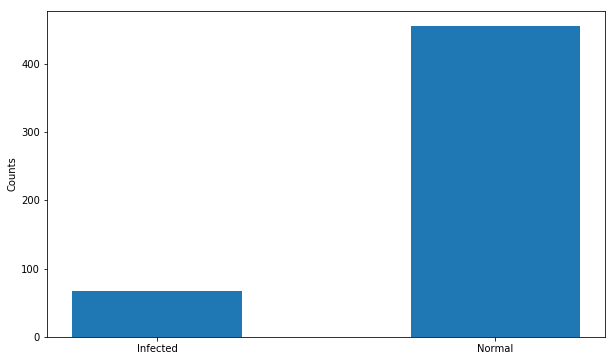

In [16]:
print("Infected hosts: ", np.sum(labels))
print("Normal hosts: ", np.sum(labels==0))
print("Imbalance ratio: ", np.sum(labels)/len(labels))
plt.figure(figsize=(10,6))
plt.bar(range(2), [np.sum(labels==1), np.sum(labels==0)], width=0.5, tick_label=['Infected', 'Normal'])
plt.ylabel('Counts')

5-fold stratified cross-validation, since the dataset on host level is much smaller and a 10-fold split would lead to really low number of training samples for the infected class.

In [17]:
num_splits = 5
cv = StratifiedKFold(n_splits = num_splits, shuffle = True)

For the documentation of the utilized helper function please refer to `helper_functions/classification.py`.

In [18]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
_, _, _, _, _, _, cm = roc_analysis(X, labels, clf, cv, False, False, False)

Reported confusion matrix, correspond to summed statistics over the 5 cross-validation splits. Reported metrics (accuracy, precision, recall, F1_score) correspond to the final, aggregated confusion matrix.

In [19]:
print(cm)

acc, prec, rec, F1 = performance_metrics(cm)

print("Accuracy: %.3f" %acc)
print("Precision: %.3f" %prec)
print("Recall: %.3f" %rec)
print("F1_score: %.3f" %F1)

[[ 11   4]
 [ 56 451]]
Accuracy: 0.885
Precision: 0.733
Recall: 0.164
F1_score: 0.268


In [20]:
from  sklearn.ensemble import RandomForestClassifier as RF

clf = RF(n_estimators='warn', criterion='gini', min_samples_split=2, min_samples_leaf=1, 
         min_weight_fraction_leaf=0.0, max_features='auto', min_impurity_decrease=0.0, 
         bootstrap=True, n_jobs=-1, verbose=0, warm_start=False)

_, _, _, _, _, _, cm = roc_analysis(X, labels, clf, cv, False, False, False)

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [21]:
print(cm)

acc, prec, rec, F1 = performance_metrics(cm)

print("Accuracy: %.3f" %acc)
print("Precision: %.3f" %prec)
print("Recall: %.3f" %rec)
print("F1_score: %.3f" %F1)

[[ 44   9]
 [ 23 446]]
Accuracy: 0.939
Precision: 0.830
Recall: 0.657
F1_score: 0.733


Creating adversarial perturbations

In [22]:
clf = GaussianNB()
_, _, _, _, _, _, cm = roc_analysis(X, labels, clf, cv, False, False, True)

In [23]:
print(cm)

acc, prec, rec, F1 = performance_metrics(cm)

print("Accuracy: %.3f" %acc)
print("Precision: %.3f" %prec)
print("Recall: %.3f" %rec)
print("F1_score: %.3f" %F1)

[[ 11   6]
 [ 56 449]]
Accuracy: 0.881
Precision: 0.647
Recall: 0.164
F1_score: 0.262


In [24]:
from  sklearn.ensemble import RandomForestClassifier as RF

clf = RF(n_estimators='warn', criterion='gini', min_samples_split=2, min_samples_leaf=1, 
         min_weight_fraction_leaf=0.0, max_features='auto', min_impurity_decrease=0.0, 
         bootstrap=True, n_jobs=-1, verbose=0, warm_start=False)

_, _, _, _, _, _, cm = roc_analysis(X, labels, clf, cv, False, False, True)

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [25]:
print(cm)

acc, prec, rec, F1 = performance_metrics(cm)

print("Accuracy: %.3f" %acc)
print("Precision: %.3f" %prec)
print("Recall: %.3f" %rec)
print("F1_score: %.3f" %F1)

[[ 23   8]
 [ 44 447]]
Accuracy: 0.900
Precision: 0.742
Recall: 0.343
F1_score: 0.469


From the reported metrics we can see that NB classifier is quite robust to the introduced perturbations. On the contrary, these perturbations have an effect on the Random-Forrest classifiers reducing the DetectionRate-Recall from 0.672 5o 0.403. 

Robustness of NB is justified to the simplicity of the classifier.

### Packet Level
Next, evaluate on the packet level.

In [26]:
data_nobground.head()

,Durat,Prot,Flags,Tos,Packets,Bytes,Flows,Label,Src_IP_Addr,Src_Port,Dst_IP_Addr,Dst_Port,Datetime,Disc_Packets
20,4.985,0,0,0,91,86277,1,0,147.32.80.13,80,147.32.85.88,56949,2011-08-18 10:19:13.347,1
51,0.000,0,1,0,1,66,1,0,147.32.86.110,48102,74.125.232.214,443,2011-08-18 10:19:13.392,0
57,4.921,0,1,0,49,3234,1,0,147.32.85.88,56949,147.32.80.13,80,2011-08-18 10:19:13.411,1
73,4.742,0,1,0,118,7080,1,0,147.32.84.59,2768,74.125.108.208,80,2011-08-18 10:19:13.460,1
75,0.000,0,1,0,1,60,1,0,147.32.84.59,56058,74.125.232.215,443,2011-08-18 10:19:13.486,0


Conversion of all features of object type to numeric.

In [27]:
# Storing the mapping used for the conversion, in case we want to revert back 
label_mapping = {}
data_num = data_nobground.copy()

# Convert currency code in order to 'amount' in a single code

# Convert all the rest columns which are of type 'object'
char_cols = data_nobground.dtypes.pipe(lambda x: x[x == 'object']).index

for c in char_cols:
    data_num[c], label_mapping[c] = pd.factorize(data_nobground[c])

# Uncomment this line, if you want to see the mapppings for the conversion
#label_mapping

In [28]:
labels = data_num['Label'].values
data_num.drop(labels=['Label', 'Datetime'], axis=1, inplace=True)
X = data_num.values
data_num.head()

,Durat,Prot,Flags,Tos,Packets,Bytes,Flows,Src_IP_Addr,Src_Port,Dst_IP_Addr,Dst_Port,Disc_Packets
20,4.985,0,0,0,91,86277,1,0,0,0,0,1
51,0.000,0,1,0,1,66,1,1,1,1,1,0
57,4.921,0,1,0,49,3234,1,2,2,2,2,1
73,4.742,0,1,0,118,7080,1,3,3,3,2,1
75,0.000,0,1,0,1,60,1,3,4,4,1,0


Demonstration of the class distribution. There is roughly equal representation of the two classes.

Infected hosts:  323441
Normal hosts:  321917
Imbalance ratio:  0.5011807399923763


Text(0, 0.5, 'Counts')

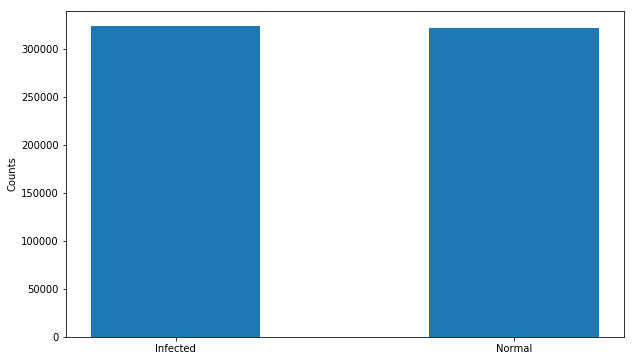

In [29]:
print("Infected hosts: ", np.sum(labels))
print("Normal hosts: ", np.sum(labels==0))
print("Imbalance ratio: ", np.sum(labels)/len(labels))
plt.figure(figsize=(10,6))
plt.bar(range(2), [np.sum(labels==1), np.sum(labels==0)], width=0.5, tick_label=['Infected', 'Normal'])
plt.ylabel('Counts')

10-fold stratified cross-validation used for evaluation.

In [30]:
num_splits = 10
cv = StratifiedKFold(n_splits = num_splits, shuffle = True)

In [31]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
_, _, _, _, _, _, cm = roc_analysis(X, labels, clf, cv, False, False, False)

In [32]:
print(cm)

acc, prec, rec, F1 = performance_metrics(cm)

print("Accuracy: %.3f" %acc)
print("Precision: %.3f" %prec)
print("Recall: %.3f" %rec)
print("F1_score: %.3f" %F1)

[[313581   4470]
 [  9860 317447]]
Accuracy: 0.978
Precision: 0.986
Recall: 0.970
F1_score: 0.978


In [33]:
from  sklearn.ensemble import RandomForestClassifier as RF

clf = RF(n_estimators='warn', criterion='gini', min_samples_split=2, min_samples_leaf=1, 
         min_weight_fraction_leaf=0.0, max_features='auto', min_impurity_decrease=0.0, 
         bootstrap=True, n_jobs=-1, verbose=0, warm_start=False)

_, _, _, _, _, _, cm = roc_analysis(X, labels, clf, cv, False, False, False)

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [34]:
print(cm)

acc, prec, rec, F1 = performance_metrics(cm)

print("Accuracy: %.3f" %acc)
print("Precision: %.3f" %prec)
print("Recall: %.3f" %rec)
print("F1_score: %.3f" %F1)

[[323434      4]
 [     7 321913]]
Accuracy: 1.000
Precision: 1.000
Recall: 1.000
F1_score: 1.000


Creating adversarial perturbations

In [35]:
clf = GaussianNB()
_, _, _, _, _, _, cm = roc_analysis(X, labels, clf, cv, False, False, True)

In [36]:
print(cm)

acc, prec, rec, F1 = performance_metrics(cm)

print("Accuracy: %.3f" %acc)
print("Precision: %.3f" %prec)
print("Recall: %.3f" %rec)
print("F1_score: %.3f" %F1)

[[314638   4468]
 [  8803 317449]]
Accuracy: 0.979
Precision: 0.986
Recall: 0.973
F1_score: 0.979


In [37]:
from  sklearn.ensemble import RandomForestClassifier as RF

clf = RF(n_estimators=10, criterion='gini', min_samples_split=2, min_samples_leaf=1, 
         min_weight_fraction_leaf=0.0, max_features='auto', min_impurity_decrease=0.0, 
         bootstrap=True, n_jobs=-1, verbose=0, warm_start=False)

_, _, _, _, _, _, cm = roc_analysis(X, labels, clf, cv, False, False, True)

In [38]:
print(cm)

acc, prec, rec, F1 = performance_metrics(cm)

print("Accuracy: %.3f" %acc)
print("Precision: %.3f" %prec)
print("Recall: %.3f" %rec)
print("F1_score: %.3f" %F1)

[[321345      1]
 [  2096 321916]]
Accuracy: 0.997
Precision: 1.000
Recall: 0.994
F1_score: 0.997


Same conclusions are extracted, as in the classification on host level